In [1]:
import pandas as pd

# for plot
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import ipywidgets as widgets

In [2]:
import re  
import pandas as pd 
from collections import defaultdict  # For word frequency
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
import missingno
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import plot_importance

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, mean_squared_error, r2_score, auc
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn import metrics
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesRegressor, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier, XGBRegressor
from sklearn.naive_bayes import MultinomialNB, BernoulliNB 
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, SGDClassifier, LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

from vecstack import stacking
from vecstack import StackingTransformer

INFO - 03:34:37: Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - 03:34:37: NumExpr defaulting to 8 threads.
Using TensorFlow backend.


## Loading Data

In [3]:
data_movies = pd.read_csv('rotten_tomatoes_movies.csv')

In [4]:
pd.set_option('display.max_columns', 50)

In [5]:
data_movies.head()

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,poster_image_url,rating,genre,directors,writers,cast,in_theaters_date,on_streaming_date,runtime_in_minutes,studio_name,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,audience_top_critics_count,audience_fresh_critics_count,audience_rotten_critics_count
0,/m/0814255,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,Though it may seem like just another Harry Pot...,https://resizing.flixster.com/p1veUpQ4ktsSHtRu...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,Craig Titley,"Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,2010-06-29,83.0,20th Century Fox,Rotten,49,144,Spilled,53.0,254287.0,38,71,73
1,/m/0878835,Please Give,Kate has a lot on her mind. There's the ethics...,Nicole Holofcener's newest might seem slight i...,https://resizing.flixster.com/0AbudQ4KsB4BeXSB...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,2010-10-19,90.0,Sony Pictures Classics,Certified Fresh,86,140,Upright,64.0,11567.0,43,121,19
2,/m/10,10,Blake Edwards' 10 stars Dudley Moore as George...,NaN,https://resizing.flixster.com/mF0dxH6UTa0FdkMs...,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,1997-08-27,118.0,Waner Bros.,Fresh,68,22,Spilled,53.0,14670.0,2,15,7
3,/m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),"A Puerto Rican youth is on trial for murder, a...",Sidney Lumet's feature debut is a superbly wri...,https://resizing.flixster.com/u-8xAyGaDVvROLiR...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,2001-03-06,95.0,Criterion Collection,Certified Fresh,100,51,Upright,97.0,105000.0,6,51,0
4,/m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea","This 1954 Disney version of Jules Verne's 20,0...","One of Disney's finest live-action adventures,...",https://resizing.flixster.com/FKExgYBHu07XLoil...,G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,2003-05-20,127.0,Disney,Fresh,89,27,Upright,74.0,68860.0,5,24,3


## Fill in NA for Categorical Values

In [6]:
data_movies[['directors','writers','cast','rating','studio_name']] = data_movies[['directors','writers','cast','rating','studio_name']].fillna('NA').applymap(str)

## Generate Director/Writer/Cast List and Stats

In [7]:
directors = data_movies['directors'].str.split(', ').tolist()
director_list = []
for director in directors:
    director_list = director_list + director
df_director = pd.DataFrame(director_list, columns=['Director'])
df_director.groupby(['Director']).size().reset_index(name='counts').to_csv('director_name.csv')

In [8]:
writers = data_movies['writers'].str.split(', ').tolist()
writer_list = []
for writer in writers:
    writer_list += writer
df_writer = pd.DataFrame(writer_list, columns=['writer'])
df_writer.groupby(['writer']).size().reset_index(name='counts').to_csv('writer_name.csv')

In [9]:
casts = data_movies['cast'].str.split(', ').tolist()
cast_list = []
for cast in casts:
    cast_list += cast
df_cast = pd.DataFrame(cast_list, columns=['cast'])
df_cast.groupby(['cast']).size().reset_index(name='counts').to_csv('cast_name.csv')

## Check that writers and directos possibly have multiple personal

In [10]:
data_movies[data_movies["directors"].str.contains(", ", na=False)].directors

17            Greggory Jacobs, Gregory Jacobs, Greg Jacobs
19                         Andy Byatt, Alastair Fothergill
20                        Michael Curtiz, William Keighley
22       Jean-Baptiste Andrea, Fabrice Canepa, Jean-Bap...
34                    Wilhelm Liebenberg, Federico Sanchez
                               ...                        
16611                        Katie Graham, Andrew Matthews
16618    Vincente Minnelli, Lemuel Ayers, Charles Walte...
16629                            Frank Coraci, Walt Becker
16634                 Byron Howard, Rich Moore, Jared Bush
16636                          Cy Endfield, Cyril Endfield
Name: directors, Length: 1709, dtype: object

In [11]:
data_movies[data_movies["writers"].str.contains(", ", na=False)].writers

5                           Roland Emmerich, Harald Kloser
6                   Alma Reville, Charles Bennett, Ian Hay
8                     Jack Weyland, Janine Whetton Gilbert
9                   Gerrit J. Lloyd, Stephen Vincent Benét
10       Hideo Hakata, Takashige Ichise, Yoshihiro Naka...
                               ...                        
16631    Justin Theroux, Ben Stiller, Nicholas Stoller,...
16632                         Adam Rifkin, David Berenbaum
16634                            Jared Bush, Phil Johnston
16636                            Cy Endfield, John Prebble
16637                          Cy Endfield, Anthony Storey
Name: writers, Length: 7442, dtype: object

In [12]:
data_movies.shape

(16638, 23)

In [13]:
data_movies.dtypes

rotten_tomatoes_link              object
movie_title                       object
movie_info                        object
critics_consensus                 object
poster_image_url                  object
rating                            object
genre                             object
directors                         object
writers                           object
cast                              object
in_theaters_date                  object
on_streaming_date                 object
runtime_in_minutes               float64
studio_name                       object
tomatometer_status                object
tomatometer_rating                 int64
tomatometer_count                  int64
audience_status                   object
audience_rating                  float64
audience_count                   float64
audience_top_critics_count         int64
audience_fresh_critics_count       int64
audience_rotten_critics_count      int64
dtype: object

## Choose only top 10 cast

In [14]:
data_movies['first_5_cast'] = data_movies['cast'].str.split(', ').str[0:5]    

In [15]:
data_movies['first_5_cast'][0]

['Logan Lerman',
 'Brandon T. Jackson',
 'Alexandra Daddario',
 'Jake Abel',
 'Sean Bean']

In [16]:
data_movies['first_5_cast'][0][0]

'Logan Lerman'

In [17]:
data_movies['first_5_cast'] = data_movies.first_5_cast.str.join(', ')

In [18]:
data_movies['first_5_cast'][0]

'Logan Lerman, Brandon T. Jackson, Alexandra Daddario, Jake Abel, Sean Bean'

## Create Dummy Variables(Dropping director/writer/cast that only appeared once)

In [19]:
%%time
data_movies_genre = data_movies.genre.str.get_dummies(sep=', ').add_prefix('genre ')

Wall time: 370 ms


In [20]:
%%time
data_movies_directors = data_movies.directors.str.get_dummies(sep=', ').add_prefix('director ')
print('Original Count of Directors\n')
print(data_movies_directors.shape[1], '\n')
print('\n')
data_movies_directors.drop([col for col, val in data_movies_directors.sum().iteritems() if val < 5], axis=1, inplace=True)
print('Director Count after removing those appear only once\n')
print(data_movies_directors.shape[1], '\n')

Original Count of Directors

9004 



Director Count after removing those appear only once

835 

Wall time: 1min 5s


In [21]:
%%time
data_movies_writers = data_movies.writers.str.get_dummies(sep=', ').add_prefix('writer ')
print('Original Count of Writers\n')
print(data_movies_writers.shape[1], '\n')
data_movies_writers.drop([col for col, val in data_movies_writers.sum().iteritems() if val < 5], axis=1, inplace=True)
print('Writer Count after removing those appear only once\n')
print(data_movies_writers.shape[1], '\n')

Original Count of Writers

14678 

Writer Count after removing those appear only once

1050 

Wall time: 2min 25s


In [22]:
%%time
data_movies_casts = data_movies.first_5_cast.str.get_dummies(sep=', ').add_prefix('cast ')
print('Original Count of Cast\n')
print(data_movies_casts.shape[1], '\n')
data_movies_casts.drop([col for col, val in data_movies_casts.sum().iteritems() if val < 5], axis=1, inplace=True)
print('Cast Count after removing those appear only once\n')
print(data_movies_casts.shape[1], '\n')

Original Count of Cast

31367 

Cast Count after removing those appear only once

3397 

Wall time: 9min 20s


In [23]:
data_movies_genre.head()

,genre Action & Adventure,genre Animation,genre Anime & Manga,genre Art House & International,genre Classics,genre Comedy,genre Cult Movies,genre Documentary,genre Drama,genre Faith & Spirituality,genre Gay & Lesbian,genre Horror,genre Kids & Family,genre Musical & Performing Arts,genre Mystery & Suspense,genre Romance,genre Science Fiction & Fantasy,genre Special Interest,genre Sports & Fitness,genre Television,genre Western
0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0


In [24]:
data_movies_directors.head()

,director Aaron Seltzer,director Abel Ferrara,director Adam Green,director Adam McKay,director Adam Rifkin,director Adam Shankman,director Adam Wingard,director Adrian García Bogliano,director Adrian Lyne,director Agnieszka Holland,director Akira Kurosawa,director Akiva Schaffer,director Alain Resnais,director Alan J. Pakula,director Alan Parker,director Alan Rudolph,director Alastair Fothergill,director Albert Brooks,director Albert Maysles,director Alejandro Amenábar,director Alejandro González Iñárritu,director Alejandro Jodorowsky,director Alex Gibney,director Alex Proyas,director Alexander Payne,...,director Walter Hill,director Walter Lang,director Walter Salles,director Warren Beatty,director Wash Westmoreland,director Wayne Wang,director Werner Herzog,director Wes Anderson,director Wes Craven,director Wilfred Jackson,director Will Gluck,director William Castle,director William Dieterle,director William Friedkin,director William Lustig,director William Wellman,director William Wyler,director Wim Wenders,director Wolfgang Petersen,director Wolfgang Reitherman,director Woo-ping Yuen,director Woody Allen,director Xavier Gens,director Zack Snyder,director Zhang Yimou
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
data_movies_writers.head()

,writer Aaron Seltzer,writer Aaron Sorkin,writer Abby Kohn,writer Abel Ferrara,writer Abi Morgan,writer Adam Brooks,writer Adam Cooper,writer Adam Gierasch,writer Adam Green,writer Adam McKay,writer Adam Rifkin,writer Adam Sandler,writer Adam Sztykiel,writer Adolph Green,writer Aeneas MacKenzie,writer Akira Kurosawa,writer Akiva Goldsman,writer Alan B. McElroy,writer Alan Burnett,writer Alan Jay Lerner,writer Alan Ormsby,writer Alan Parker,writer Alan Rudolph,writer Alan Sharp,writer Albert Brooks,...,writer Werner Herzog,writer Wes Anderson,writer Wes Craven,writer Wesley Strick,writer Will Aldis,writer Will Ferrell,writer Will McRobb,writer Willard Huyck,writer William Broyles,writer William D. Wittliff,writer William Davies,writer William Faulkner,writer William Goldman,writer William Monahan,writer William Nicholson,writer William Norton,writer William Osborne,writer William Peter Blatty,writer William Rose,writer William Wisher Jr.,writer Wim Wenders,writer Winston Hibler,writer Woody Allen,writer Zak Penn,writer Zhang Yimou
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [26]:
data_movies_casts.head()

,cast 50 Cent,cast AJ Bowen,cast Aamir Khan,cast Aaron Eckhart,cast Aaron Paul,cast Aaron Poole,cast Aaron Stanford,cast Aaron Taylor-Johnson,cast Aaron Yoo,cast Abbie Cornish,cast Abe Vigoda,cast Abhishek Bachchan,cast Abigail Breslin,cast Adam Arkin,cast Adam Baldwin,cast Adam Beach,cast Adam Brody,cast Adam Carolla,cast Adam DeVine,cast Adam Driver,cast Adam Garcia,cast Adam Goldberg,cast Adam Pally,cast Adam Sandler,cast Adam Scott,...,cast Yaphet Kotto,cast Yasiin Bey,cast Ye Liu,cast Yul Brynner,cast Yul Vázquez,cast Yun-Fat Chow,cast Yves Montand,cast Yvonne De Carlo,cast Yvonne Strahovski,cast Zac Efron,cast Zach Braff,cast Zach Galifianakis,cast Zach Gilford,cast Zachary Levi,cast Zachary Quinto,cast Zazie Beetz,cast Zero Mostel,cast Ziyi Zhang,cast Zoe Kazan,cast Zoe Lister-Jones,cast Zoe Saldana,cast Zoey Deutch,cast Zooey Deschanel,cast Zoë Kravitz,cast Ángela Molina
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Joining All the dummy variables for Director/Writer/Cast names

In [27]:
df = pd.concat([data_movies,
                data_movies_genre,
                data_movies_directors,
                data_movies_writers,
                data_movies_casts
          ],1)

In [28]:
df.head()

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,poster_image_url,rating,genre,directors,writers,cast,in_theaters_date,on_streaming_date,runtime_in_minutes,studio_name,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,audience_top_critics_count,audience_fresh_critics_count,audience_rotten_critics_count,first_5_cast,genre Action & Adventure,...,cast Yaphet Kotto,cast Yasiin Bey,cast Ye Liu,cast Yul Brynner,cast Yul Vázquez,cast Yun-Fat Chow,cast Yves Montand,cast Yvonne De Carlo,cast Yvonne Strahovski,cast Zac Efron,cast Zach Braff,cast Zach Galifianakis,cast Zach Gilford,cast Zachary Levi,cast Zachary Quinto,cast Zazie Beetz,cast Zero Mostel,cast Ziyi Zhang,cast Zoe Kazan,cast Zoe Lister-Jones,cast Zoe Saldana,cast Zoey Deutch,cast Zooey Deschanel,cast Zoë Kravitz,cast Ángela Molina
0,/m/0814255,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,Though it may seem like just another Harry Pot...,https://resizing.flixster.com/p1veUpQ4ktsSHtRu...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,Craig Titley,"Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,2010-06-29,83.0,20th Century Fox,Rotten,49,144,Spilled,53.0,254287.0,38,71,73,"Logan Lerman, Brandon T. Jackson, Alexandra Da...",1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,/m/0878835,Please Give,Kate has a lot on her mind. There's the ethics...,Nicole Holofcener's newest might seem slight i...,https://resizing.flixster.com/0AbudQ4KsB4BeXSB...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,2010-10-19,90.0,Sony Pictures Classics,Certified Fresh,86,140,Upright,64.0,11567.0,43,121,19,"Catherine Keener, Amanda Peet, Oliver Platt, R...",0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,/m/10,10,Blake Edwards' 10 stars Dudley Moore as George...,NaN,https://resizing.flixster.com/mF0dxH6UTa0FdkMs...,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,1997-08-27,118.0,Waner Bros.,Fresh,68,22,Spilled,53.0,14670.0,2,15,7,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,/m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),"A Puerto Rican youth is on trial for murder, a...",Sidney Lumet's feature debut is a superbly wri...,https://resizing.flixster.com/u-8xAyGaDVvROLiR...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,2001-03-06,95.0,Criterion Collection,Certified Fresh,100,51,Upright,97.0,105000.0,6,51,0,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,/m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea","This 1954 Disney version of Jules Verne's 20,0...","One of Disney's finest live-action adventures,...",https://resizing.flixster.com/FKExgYBHu07XLoil...,G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,2003-05-20,127.0,Disney,Fresh,89,27,Upright,74.0,68860.0,5,24,3,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
data_movies.dtypes

rotten_tomatoes_link              object
movie_title                       object
movie_info                        object
critics_consensus                 object
poster_image_url                  object
rating                            object
genre                             object
directors                         object
writers                           object
cast                              object
in_theaters_date                  object
on_streaming_date                 object
runtime_in_minutes               float64
studio_name                       object
tomatometer_status                object
tomatometer_rating                 int64
tomatometer_count                  int64
audience_status                   object
audience_rating                  float64
audience_count                   float64
audience_top_critics_count         int64
audience_fresh_critics_count       int64
audience_rotten_critics_count      int64
first_5_cast                      object
dtype: object

In [30]:
# df = pd.concat([data_movies,
#            data_movies.directors.str.get_dummies(sep=', ').add_prefix('director '),
#            data_movies.writers.str.get_dummies(sep=', ').add_prefix('writer '),
#            data_movies.cast.str.get_dummies(sep=', ').add_prefix('cast '),
#           ],1)

## Creating other dummy variables

In [31]:
df['in_theaters_date'] = pd.to_datetime(df.in_theaters_date)

In [32]:
df['on_streaming_date'] = pd.to_datetime(df.on_streaming_date)

In [33]:
df['in_theaters_year'] = df['in_theaters_date'].apply(lambda x: x.year)

In [34]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

In [35]:
df.rating = df.rating.str.replace(")", "")

In [36]:
df.rating = df.rating.str.replace("-13", "")

In [37]:
df.rating.unique()

array(['PG', 'R', 'NR', 'G', 'NC17'], dtype=object)

In [38]:
print(df.studio_name.unique().dtype)

object


In [39]:
df.groupby(['studio_name']).size().reset_index(name='counts')

,studio_name,counts
0,10 West Studios,1
1,108 Pics,1
2,1091,1
3,120 Degree Films,1
4,1428 Films,1
...,...,...
2882,eRealBiz,2
2883,iHQ,1
2884,levelFILM,2
2885,nWave Pictures,1


In [40]:
df[['in_theaters_year']] = df[['in_theaters_year']].fillna('NA').applymap(str)

In [41]:
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')
# passing bridge-types-cat column (label encoded values of bridge_types)
train_encoded = enc.fit_transform(df[['rating','studio_name']]).toarray()
column_name = enc.get_feature_names()
enc_df =  pd.DataFrame(train_encoded, columns= column_name)
enc_df.head()

,x0_G,x0_NC17,x0_NR,x0_PG,x0_R,x1_10 West Studios,x1_108 Pics,x1_1091,x1_120 Degree Films,x1_1428 Films,x1_1821 Pictures,x1_20th Century Fox,x1_20th Century Fox Distribution,x1_20th Century Fox Film,x1_20th Century Fox Film Corp.,x1_20th Century Fox Film Corporat,x1_20th Century Fox Film Corporation,x1_20th Century Fox Television,x1_20th Century Fox/Emerging Pictures,x1_20th Century Fox/Regency Films,x1_20th Century-Fox,x1_21 Laps Entertainment,x1_21UNO FILM,x1_21st Century Distribution,x1_21st Century Film Corporation,...,x1_Zeitgeist Films,x1_Zenith Entertainment,x1_Zenith International Films,x1_Zenith International Films Inc,x1_Zentropa Entertainments,x1_Zentropa Productions,x1_Zero Point Zero Films,x1_Zik Zak Filmworks,x1_Zipper Bros. Films,x1_Zipporah Films,x1_Zodiac Pictures,x1_Zombot Pictures,x1_Zorro and Me Films,x1_Zubara Films,x1_Zweites Deutsches Fernsehen,x1_cinTBLAST!,x1_deRochemont Films,x1_eOne,x1_eOne Entertainment,x1_eOne Entertainment Distribution,x1_eRealBiz,x1_iHQ,x1_levelFILM,x1_nWave Pictures,x1_s
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Dropping Onehot Encoder where sum < 10

In [42]:
enc_df.shape

(16638, 2892)

In [43]:
%%time
enc_df.drop([col for col, val in enc_df.sum().iteritems() if val < 10], axis=1, inplace=True)

Wall time: 389 ms


In [44]:
enc_df.shape

(16638, 218)

## Joining Final Dataset

In [45]:
df_processed = pd.concat([df,
                enc_df],1)

In [46]:
df_processed = df_processed[df_processed['audience_rating'].notna()]

In [47]:
df_processed.fillna(0)

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,poster_image_url,rating,genre,directors,writers,cast,in_theaters_date,on_streaming_date,runtime_in_minutes,studio_name,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,audience_top_critics_count,audience_fresh_critics_count,audience_rotten_critics_count,first_5_cast,genre Action & Adventure,...,x1_United Artists,x1_Universal,x1_Universal Pictures,x1_Universal Studios,x1_Universal Studios Home Video,x1_Vanguard,x1_Variance Films,x1_Vertical Entertainment,x1_Vestron Video,x1_WARNER BROTHERS PICTURES,x1_Walt Disney Home Entertainment,x1_Walt Disney Pictures,x1_Walt Disney Productions,x1_Warner Bros.,x1_Warner Bros. Pictures,x1_Warner Home Video,x1_Warner Independent Pictures,x1_Weinstein Company,x1_Well Go USA,x1_Well Go USA Entertainment,x1_Wolfe Releasing,x1_Xlrator Media,x1_Yari Film Group,x1_Yash Raj Films,x1_Zeitgeist Films
0,/m/0814255,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,Though it may seem like just another Harry Pot...,https://resizing.flixster.com/p1veUpQ4ktsSHtRu...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,Craig Titley,"Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12 00:00:00,2010-06-29 00:00:00,83.0,20th Century Fox,Rotten,49,144,Spilled,53.0,254287.0,38,71,73,"Logan Lerman, Brandon T. Jackson, Alexandra Da...",1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,/m/0878835,Please Give,Kate has a lot on her mind. There's the ethics...,Nicole Holofcener's newest might seem slight i...,https://resizing.flixster.com/0AbudQ4KsB4BeXSB...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30 00:00:00,2010-10-19 00:00:00,90.0,Sony Pictures Classics,Certified Fresh,86,140,Upright,64.0,11567.0,43,121,19,"Catherine Keener, Amanda Peet, Oliver Platt, R...",0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,/m/10,10,Blake Edwards' 10 stars Dudley Moore as George...,0,https://resizing.flixster.com/mF0dxH6UTa0FdkMs...,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05 00:00:00,1997-08-27 00:00:00,118.0,Waner Bros.,Fresh,68,22,Spilled,53.0,14670.0,2,15,7,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,/m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),"A Puerto Rican youth is on trial for murder, a...",Sidney Lumet's feature debut is a superbly wri...,https://resizing.flixster.com/u-8xAyGaDVvROLiR...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13 00:00:00,2001-03-06 00:00:00,95.0,Criterion Collection,Certified Fresh,100,51,Upright,97.0,105000.0,6,51,0,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,/m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea","This 1954 Disney version of Jules Verne's 20,0...","One of Disney's finest live-action adventures,...",https://resizing.flixster.com/FKExgYBHu07XLoil...,G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01 00:00:00,2003-05-20 00:00:00,127.0,Disney,Fresh,89,27,Upright,74.0,68860.0,5,24,3,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16633,/m/zoot

In [48]:
df_processed.head()

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,poster_image_url,rating,genre,directors,writers,cast,in_theaters_date,on_streaming_date,runtime_in_minutes,studio_name,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,audience_top_critics_count,audience_fresh_critics_count,audience_rotten_critics_count,first_5_cast,genre Action & Adventure,...,x1_United Artists,x1_Universal,x1_Universal Pictures,x1_Universal Studios,x1_Universal Studios Home Video,x1_Vanguard,x1_Variance Films,x1_Vertical Entertainment,x1_Vestron Video,x1_WARNER BROTHERS PICTURES,x1_Walt Disney Home Entertainment,x1_Walt Disney Pictures,x1_Walt Disney Productions,x1_Warner Bros.,x1_Warner Bros. Pictures,x1_Warner Home Video,x1_Warner Independent Pictures,x1_Weinstein Company,x1_Well Go USA,x1_Well Go USA Entertainment,x1_Wolfe Releasing,x1_Xlrator Media,x1_Yari Film Group,x1_Yash Raj Films,x1_Zeitgeist Films
0,/m/0814255,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,Though it may seem like just another Harry Pot...,https://resizing.flixster.com/p1veUpQ4ktsSHtRu...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,Craig Titley,"Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,2010-06-29,83.0,20th Century Fox,Rotten,49,144,Spilled,53.0,254287.0,38,71,73,"Logan Lerman, Brandon T. Jackson, Alexandra Da...",1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,/m/0878835,Please Give,Kate has a lot on her mind. There's the ethics...,Nicole Holofcener's newest might seem slight i...,https://resizing.flixster.com/0AbudQ4KsB4BeXSB...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,2010-10-19,90.0,Sony Pictures Classics,Certified Fresh,86,140,Upright,64.0,11567.0,43,121,19,"Catherine Keener, Amanda Peet, Oliver Platt, R...",0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,/m/10,10,Blake Edwards' 10 stars Dudley Moore as George...,NaN,https://resizing.flixster.com/mF0dxH6UTa0FdkMs...,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,1997-08-27,118.0,Waner Bros.,Fresh,68,22,Spilled,53.0,14670.0,2,15,7,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,/m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),"A Puerto Rican youth is on trial for murder, a...",Sidney Lumet's feature debut is a superbly wri...,https://resizing.flixster.com/u-8xAyGaDVvROLiR...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,2001-03-06,95.0,Criterion Collection,Certified Fresh,100,51,Upright,97.0,105000.0,6,51,0,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,/m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea","This 1954 Disney version of Jules Verne's 20,0...","One of Disney's finest live-action adventures,...",https://resizing.flixster.com/FKExgYBHu07XLoil...,G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,2003-05-20,127.0,Disney,Fresh,89,27,Upright,74.0,68860.0,5,24,3,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
df_processed.columns

Index(['rotten_tomatoes_link', 'movie_title', 'movie_info',
       'critics_consensus', 'poster_image_url', 'rating', 'genre', 'directors',
       'writers', 'cast',
       ...
       'x1_Warner Home Video', 'x1_Warner Independent Pictures',
       'x1_Weinstein Company', 'x1_Well Go USA',
       'x1_Well Go USA Entertainment', 'x1_Wolfe Releasing',
       'x1_Xlrator Media', 'x1_Yari Film Group', 'x1_Yash Raj Films',
       'x1_Zeitgeist Films'],
      dtype='object', length=5546)

## Change Certified Fresh to Fresh

In [50]:
df_processed.tomatometer_status = df_processed.tomatometer_status.str.replace("Certified Fresh", "Fresh")

## Spliting X and y

In [51]:
X=df_processed.drop(['rating','rotten_tomatoes_link','movie_title','movie_info','critics_consensus','poster_image_url','genre','directors','writers','cast','in_theaters_date','on_streaming_date','studio_name','tomatometer_status','tomatometer_rating','tomatometer_count','audience_status','audience_rating','audience_count','audience_top_critics_count','audience_fresh_critics_count','audience_rotten_critics_count','first_5_cast','in_theaters_year'],axis=1)
y=df_processed[['tomatometer_status','tomatometer_rating','audience_rating']]

In [52]:
X.runtime_in_minutes = X['runtime_in_minutes'].fillna(0)

In [53]:
scaler = StandardScaler()
X['runtime_in_minutes'] = scaler.fit_transform(X[['runtime_in_minutes']])

In [54]:
X.head()

,runtime_in_minutes,genre Action & Adventure,genre Animation,genre Anime & Manga,genre Art House & International,genre Classics,genre Comedy,genre Cult Movies,genre Documentary,genre Drama,genre Faith & Spirituality,genre Gay & Lesbian,genre Horror,genre Kids & Family,genre Musical & Performing Arts,genre Mystery & Suspense,genre Romance,genre Science Fiction & Fantasy,genre Special Interest,genre Sports & Fitness,genre Television,genre Western,director Aaron Seltzer,director Abel Ferrara,director Adam Green,...,x1_United Artists,x1_Universal,x1_Universal Pictures,x1_Universal Studios,x1_Universal Studios Home Video,x1_Vanguard,x1_Variance Films,x1_Vertical Entertainment,x1_Vestron Video,x1_WARNER BROTHERS PICTURES,x1_Walt Disney Home Entertainment,x1_Walt Disney Pictures,x1_Walt Disney Productions,x1_Warner Bros.,x1_Warner Bros. Pictures,x1_Warner Home Video,x1_Warner Independent Pictures,x1_Weinstein Company,x1_Well Go USA,x1_Well Go USA Entertainment,x1_Wolfe Releasing,x1_Xlrator Media,x1_Yari Film Group,x1_Yash Raj Films,x1_Zeitgeist Films
0,-0.697313,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.435495,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.611780,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.248481,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.948404,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Missing value check

In [55]:
null_columns=X.columns[X.isnull().any()]
X[null_columns].isnull().sum()

Series([], dtype: float64)

In [56]:
null_columns=y.columns[y.isnull().any()]
y[null_columns].isnull().sum()

Series([], dtype: float64)

In [57]:
y.tomatometer_status.unique()

array(['Rotten', 'Fresh'], dtype=object)

In [58]:
mapping = {'Rotten': 0, 'Fresh': 1}

y = y.replace({'tomatometer_status': mapping})

In [59]:
y.head()

,tomatometer_status,tomatometer_rating,audience_rating
0,0,49,53.0
1,1,86,64.0
2,1,68,53.0
3,1,100,97.0
4,1,89,74.0


In [60]:
y.dtypes

tomatometer_status      int64
tomatometer_rating      int64
audience_rating       float64
dtype: object

In [61]:
y.tomatometer_rating = y.tomatometer_rating.astype('float64')

In [62]:
y.dtypes

tomatometer_status      int64
tomatometer_rating    float64
audience_rating       float64
dtype: object

## Train Test Split

In [63]:
from sklearn.model_selection import train_test_split
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, test_size = 0.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(13108, 5522)
(3278, 5522)
(13108, 3)
(3278, 3)


In [64]:
y_train_tomatometer_status = y_train['tomatometer_status']
y_test_tomatometer_status = y_test['tomatometer_status']
y_train_tomatometer_rating = y_train['tomatometer_rating']
y_test_tomatometer_rating = y_test['tomatometer_rating']
y_train_audience_rating = y_train['audience_rating']
y_test_audience_rating = y_test['audience_rating']

In [65]:
pd.set_option('display.max_columns', None)

# Model Training: Tomatometer_status

In [68]:
%%time
#Computing for each model with SMOTE sampling: accuracy, precision and recall 

logreg = LogisticRegression(random_state=10)
knn = KNeighborsClassifier(n_neighbors=3)
clf = DecisionTreeClassifier(random_state=10)
RandomForest = RandomForestClassifier(random_state=10)
adaboost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=100,random_state=10)
DecisionTree_XGB = XGBClassifier(n_estimators=100, objective='binary:logistic',seed=10)
SGD = SGDClassifier(loss='log',random_state=10)
extratree = ExtraTreesClassifier(random_state=10)
gnb = GaussianNB()


models=[logreg,knn,clf,RandomForest,adaboost,DecisionTree_XGB,SGD,extratree,gnb]

model_accuracy_test=[]
model_accuracy_train=[]
precisions=[]
recalls=[]
for model in models:
    print("\nNow training \n")
    print(type(model).__name__)
    model.fit(X_train, y_train_tomatometer_status)
    model_accuracy_train.append(model.score(X_train, y_train_tomatometer_status))
    model_accuracy_test.append(accuracy_score(y_test_tomatometer_status, model.predict(X_test)))
    
    report=precision_recall_fscore_support(y_test_tomatometer_status, model.predict(X_test))
    precisions.append(report[0][1])
    recalls.append(report[1][1])
   


Now training 

LogisticRegression


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




Now training 

KNeighborsClassifier

Now training 

DecisionTreeClassifier

Now training 

RandomForestClassifier

Now training 

AdaBoostClassifier

Now training 

XGBClassifier

Now training 

SGDClassifier

Now training 

ExtraTreesClassifier

Now training 

GaussianNB
Wall time: 20min 40s


In [69]:
# consolidation of the results in one table

acc_train_df=pd.DataFrame(model_accuracy_train,index=['LogisticRegression','KNN','DecisionTree','RandomForest','AdaBoost','DecisionTree_XGB','SGDClassifier','ExtraTreesClassifier','GaussianNB'], columns=['acc_train'])
acc_test_df=pd.DataFrame(model_accuracy_test,index=['LogisticRegression','KNN','DecisionTree','RandomForest','AdaBoost','DecisionTree_XGB','SGDClassifier','ExtraTreesClassifier','GaussianNB'],columns=['acc_test'])
precisions_df=pd.DataFrame(precisions,index=['LogisticRegression','KNN','DecisionTree','RandomForest','AdaBoost','DecisionTree_XGB','SGDClassifier','ExtraTreesClassifier','GaussianNB'],columns=['precision class 1'])
recalls_df=pd.DataFrame(recalls,index=['LogisticRegression','KNN','DecisionTree','RandomForest','AdaBoost','DecisionTree_XGB','SGDClassifier','ExtraTreesClassifier','GaussianNB'],columns=['recall class 1'])

model_accuracy=pd.concat([acc_train_df,acc_test_df,precisions_df,recalls_df], axis=1)
model_accuracy

,acc_train,acc_test,precision class 1,recall class 1
LogisticRegression,0.851846,0.712935,0.728659,0.778924
KNN,0.798596,0.611959,0.636713,0.719718
DecisionTree,0.997864,0.636059,0.674946,0.678979
RandomForest,0.997864,0.690665,0.710647,0.757740
AdaBoost,0.709414,0.683038,0.728620,0.694188
DecisionTree_XGB,0.759231,0.701952,0.736324,0.731124
SGDClassifier,0.842234,0.714460,0.737284,0.763715
ExtraTreesClassifier,0.997864,0.672361,0.703017,0.721347
GaussianNB,0.663335,0.590909,0.764831,0.392178


## XGBoost Feature Importance

In [70]:
feature_importance = DecisionTree_XGB.feature_importances_
df_feature = pd.DataFrame(data=feature_importance, index=[X.columns], columns = ['importance'])
df_feature.to_csv('feature importance.csv') 

In [71]:
df_feature.sort_values('importance', ascending=True)[-15:]

,importance
x1_Buena Vista,0.003930
x1_Focus Features,0.003963
director Joel Coen,0.004035
x1_Vertical Entertainment,0.004264
x1_Criterion Collection,0.004434
genre Drama,0.004460
x0_G,0.004485
x1_United Artists,0.004525
cast Rose Byrne,0.005499
x1_Sony Pictures Classics,0.008664


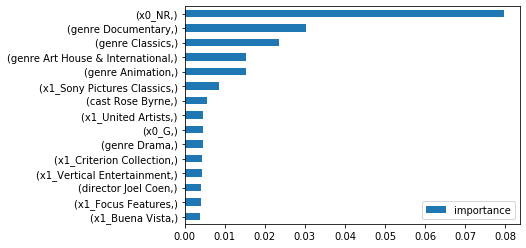

In [72]:
ax = df_feature.sort_values('importance', ascending=True)[-15:].plot.barh(y='importance')

## Logistic Regression Result

In [73]:
pred_result = pd.DataFrame({'actual rating': y_test_tomatometer_status, 'pred rating': logreg.predict(X_test)})

In [74]:
pred_result

,actual rating,pred rating
5234,1,0
9036,1,1
11273,0,0
3947,0,1
15398,0,1
...,...,...
14237,0,1
6099,0,0
907,1,1
15823,1,1


## Gridsearch Logistic Regression

In [75]:
# Grid search cross validation
import numpy as np
from sklearn.model_selection import GridSearchCV
grid={"C":np.logspace(-3,1,5), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg_cv=GridSearchCV(logreg,grid,cv=5,verbose=10)

In [76]:
logreg_cv.fit(X_train, y_train_tomatometer_status)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] C=0.001, penalty=l1 .............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ................... C=0.001, penalty=l1, score=nan, total=   0.2s
[CV] C=0.001, penalty=l1 .............................................
[CV] ................... C=0.001, penalty=l1, score=nan, total=   0.2s
[CV] C=0.001, penalty=l1 .............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] ................... C=0.001, penalty=l1, score=nan, total=   0.2s
[CV] C=0.001, penalty=l1 .............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s


[CV] ................... C=0.001, penalty=l1, score=nan, total=   0.2s
[CV] C=0.001, penalty=l1 .............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.0s remaining:    0.0s


[CV] ................... C=0.001, penalty=l1, score=nan, total=   0.2s
[CV] C=0.001, penalty=l2 .............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s remaining:    0.0s


[CV] ................. C=0.001, penalty=l2, score=0.657, total=   1.7s
[CV] C=0.001, penalty=l2 .............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.9s remaining:    0.0s


[CV] ................. C=0.001, penalty=l2, score=0.678, total=   1.7s
[CV] C=0.001, penalty=l2 .............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    4.7s remaining:    0.0s


[CV] ................. C=0.001, penalty=l2, score=0.651, total=   1.7s
[CV] C=0.001, penalty=l2 .............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    6.4s remaining:    0.0s


[CV] ................. C=0.001, penalty=l2, score=0.667, total=   1.7s
[CV] C=0.001, penalty=l2 .............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    8.1s remaining:    0.0s


[CV] ................. C=0.001, penalty=l2, score=0.661, total=   1.7s
[CV] C=0.01, penalty=l1 ..............................................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.




[CV] .................... C=0.01, penalty=l1, score=nan, total=   0.2s
[CV] C=0.01, penalty=l1 ..............................................
[CV] .................... C=0.01, penalty=l1, score=nan, total=   0.2s
[CV] C=0.01, penalty=l1 ..............................................
[CV] .................... C=0.01, penalty=l1, score=nan, total=   0.2s
[CV] C=0.01, penalty=l1 ..............................................
[CV] .................... C=0.01, penalty=l1, score=nan, total=   0.2s
[CV] C=0.01, penalty=l1 ..............................................
[CV] .................... C=0.01, penalty=l1, score=nan, total=   0.2s
[CV] C=0.01, penalty=l2 ..............................................
[CV] .................. C=0.01, penalty=l2, score=0.690, total=   2.2s
[CV] C=0.01, penalty=l2 ..............................................
[CV] .................. C=0.01, penalty=l2, score=0.705, total=   2.1s
[CV] C=0.01, penalty=l2 ..............................................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.




[CV] ..................... C=0.1, penalty=l1, score=nan, total=   0.2s
[CV] C=0.1, penalty=l1 ...............................................
[CV] ..................... C=0.1, penalty=l1, score=nan, total=   0.2s
[CV] C=0.1, penalty=l1 ...............................................
[CV] ..................... C=0.1, penalty=l1, score=nan, total=   0.2s
[CV] C=0.1, penalty=l1 ...............................................
[CV] ..................... C=0.1, penalty=l1, score=nan, total=   0.2s
[CV] C=0.1, penalty=l1 ...............................................
[CV] ..................... C=0.1, penalty=l1, score=nan, total=   0.2s
[CV] C=0.1, penalty=l2 ...............................................
[CV] ................... C=0.1, penalty=l2, score=0.715, total=   3.9s
[CV] C=0.1, penalty=l2 ...............................................
[CV] ................... C=0.1, penalty=l2, score=0.717, total=   4.0s
[CV] C=0.1, penalty=l2 ...............................................
[CV] .

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.




[CV] ..................... C=1.0, penalty=l1, score=nan, total=   0.2s
[CV] C=1.0, penalty=l1 ...............................................
[CV] ..................... C=1.0, penalty=l1, score=nan, total=   0.2s
[CV] C=1.0, penalty=l1 ...............................................
[CV] ..................... C=1.0, penalty=l1, score=nan, total=   0.2s
[CV] C=1.0, penalty=l1 ...............................................
[CV] ..................... C=1.0, penalty=l1, score=nan, total=   0.2s
[CV] C=1.0, penalty=l1 ...............................................
[CV] ..................... C=1.0, penalty=l1, score=nan, total=   0.2s
[CV] C=1.0, penalty=l2 ...............................................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] ................... C=1.0, penalty=l2, score=0.709, total=   6.1s
[CV] C=1.0, penalty=l2 ...............................................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] ................... C=1.0, penalty=l2, score=0.709, total=   6.0s
[CV] C=1.0, penalty=l2 ...............................................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] ................... C=1.0, penalty=l2, score=0.695, total=   6.1s
[CV] C=1.0, penalty=l2 ...............................................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] ................... C=1.0, penalty=l2, score=0.709, total=   5.9s
[CV] C=1.0, penalty=l2 ...............................................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] ................... C=1.0, penalty=l2, score=0.699, total=   5.9s
[CV] C=10.0, penalty=l1 ..............................................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.




[CV] .................... C=10.0, penalty=l1, score=nan, total=   0.2s
[CV] C=10.0, penalty=l1 ..............................................
[CV] .................... C=10.0, penalty=l1, score=nan, total=   0.2s
[CV] C=10.0, penalty=l1 ..............................................
[CV] .................... C=10.0, penalty=l1, score=nan, total=   0.2s
[CV] C=10.0, penalty=l1 ..............................................
[CV] .................... C=10.0, penalty=l1, score=nan, total=   0.2s
[CV] C=10.0, penalty=l1 ..............................................
[CV] .................... C=10.0, penalty=l1, score=nan, total=   0.2s
[CV] C=10.0, penalty=l2 ..............................................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] .................. C=10.0, penalty=l2, score=0.682, total=   5.9s
[CV] C=10.0, penalty=l2 ..............................................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] .................. C=10.0, penalty=l2, score=0.691, total=   5.8s
[CV] C=10.0, penalty=l2 ..............................................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] .................. C=10.0, penalty=l2, score=0.664, total=   5.9s
[CV] C=10.0, penalty=l2 ..............................................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] .................. C=10.0, penalty=l2, score=0.677, total=   6.0s
[CV] C=10.0, penalty=l2 ..............................................


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.8min finished


[CV] .................. C=10.0, penalty=l2, score=0.675, total=   5.9s


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=10, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=10)

## Logistic Regression Results

In [77]:
y_pred_proba = logreg_cv.predict_proba(X_test)[:, 1]
y_pred_proba

array([0.43981107, 0.53000214, 0.18584753, ..., 0.88589399, 0.87083904,
       0.29198994])

In [78]:
from sklearn.metrics import classification_report, confusion_matrix
threshold = 0.5
y_pred = y_pred_proba >= threshold
print(classification_report(y_test_tomatometer_status, y_pred))
pd.DataFrame(confusion_matrix(y_test_tomatometer_status, y_pred), 
             columns=['Predicted Negative', 'Predicted Positive'], 
             index=['Actual Negative', 'Actual Positive'])

              precision    recall  f1-score   support

           0       0.69      0.67      0.68      1437
           1       0.75      0.76      0.75      1841

    accuracy                           0.72      3278
   macro avg       0.72      0.72      0.72      3278
weighted avg       0.72      0.72      0.72      3278



,Predicted Negative,Predicted Positive
Actual Negative,963,474
Actual Positive,440,1401


Area under the Receiver Operating Characteristic curve: 0.7769521042578822


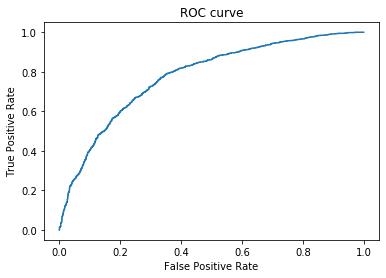

In [79]:
from sklearn.metrics import roc_auc_score, roc_curve
fpr, tpr, thresholds = roc_curve(y_test_tomatometer_status, y_pred_proba)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('Area under the Receiver Operating Characteristic curve:', 
      roc_auc_score(y_test_tomatometer_status, y_pred_proba))

## Logistic Regression Feature Importance

In [80]:
importance = logreg_cv.best_estimator_.coef_[0]

In [81]:
d = {'feature_name': X.columns, 'importance': importance}

In [82]:
df_logreg_feature_importance =  pd.DataFrame(data=d)

In [83]:
df_logreg_feature_importance['importance_abs'] = np.abs(df_logreg_feature_importance.importance)

In [84]:
df_logreg_feature_importance.sort_values('importance_abs', ascending=False)[:15]

,feature_name,importance,importance_abs
8,genre Documentary,1.517995,1.517995
5,genre Classics,1.291300,1.291300
5469,x1_Sony Pictures Classics,0.886217,0.886217
5341,x1_Criterion Collection,0.706809,0.706809
5414,x1_Music Box Films,0.702792,0.702792
2,genre Animation,0.686742,0.686742
4,genre Art House & International,0.603311,0.603311
5368,x1_Freestyle Releasing,-0.576298,0.576298
5452,x1_Regent Releasing,-0.549516,0.549516
5497,x1_United Artists,0.545074,0.545074


## Cast Importance Rank

In [85]:
df_logreg_feature_importance[df_logreg_feature_importance['feature_name'].str.contains('cast ')].sort_values('importance', ascending=False)[:5]

,feature_name,importance,importance_abs
3003,cast Geena Davis,0.468787,0.468787
3471,cast Jim Broadbent,0.461437,0.461437
4195,cast Michael Cera,0.403924,0.403924
4182,cast Meryl Streep,0.396812,0.396812
4554,cast Ralph Fiennes,0.393185,0.393185


In [86]:
df_logreg_feature_importance[df_logreg_feature_importance['feature_name'].str.contains('cast ')].sort_values('importance', ascending=True)[:5]

,feature_name,importance,importance_abs
3138,cast Heather Graham,-0.519576,0.519576
3425,cast Jennifer Lopez,-0.437272,0.437272
2614,cast Danny Dyer,-0.437146,0.437146
4608,cast Richard Burton,-0.434930,0.434930
2855,cast Elvis Presley,-0.417215,0.417215


## Director Importance Rank

In [87]:
df_logreg_feature_importance[df_logreg_feature_importance['feature_name'].str.contains('director ')].sort_values('importance', ascending=False)[:5]

,feature_name,importance,importance_abs
776,director Steven Spielberg,0.461393,0.461393
184,director David Cronenberg,0.456390,0.456390
533,director Martin Scorsese,0.424106,0.424106
638,director Peter Weir,0.408908,0.408908
648,director Quentin Tarantino,0.375568,0.375568


In [88]:
df_logreg_feature_importance[df_logreg_feature_importance['feature_name'].str.contains('director ')].sort_values('importance', ascending=True)[:5]

,feature_name,importance,importance_abs
335,director J. Lee Thompson,-0.366039,0.366039
820,director Tyler Perry,-0.300144,0.300144
738,director Sean McNamara,-0.254141,0.254141
609,director Otto Preminger,-0.251029,0.251029
352,director James Ivory,-0.241843,0.241843


## Writer Importance Rank

In [89]:
df_logreg_feature_importance[df_logreg_feature_importance['feature_name'].str.contains('writer ')].sort_values('importance', ascending=False)[:5]

,feature_name,importance,importance_abs
1794,writer Steve Kloves,0.343288,0.343288
1666,writer Quentin Tarantino,0.338405,0.338405
1173,writer Ethan Coen,0.329056,0.329056
1359,writer Joel Coen,0.329056,0.329056
1683,writer Richard Maibaum,0.288134,0.288134


In [90]:
df_logreg_feature_importance[df_logreg_feature_importance['feature_name'].str.contains('writer ')].sort_values('importance', ascending=True)[:5]

,feature_name,importance,importance_abs
1731,writer Ronald Bass,-0.365923,0.365923
1864,writer Tyler Perry,-0.285957,0.285957
1512,writer Marlon Wayans,-0.230118,0.230118
896,writer Allan Loeb,-0.222875,0.222875
945,writer Bill Collage,-0.221457,0.221457


## Genre Importance Rank

In [91]:
df_logreg_feature_importance[df_logreg_feature_importance['feature_name'].str.contains('genre ')].sort_values('importance', ascending=False)[:5]

,feature_name,importance,importance_abs
8,genre Documentary,1.517995,1.517995
5,genre Classics,1.291300,1.291300
2,genre Animation,0.686742,0.686742
4,genre Art House & International,0.603311,0.603311
9,genre Drama,0.366141,0.366141


In [92]:
df_logreg_feature_importance[df_logreg_feature_importance['feature_name'].str.contains('genre ')].sort_values('importance', ascending=True)[:5]

,feature_name,importance,importance_abs
10,genre Faith & Spirituality,-0.415261,0.415261
11,genre Gay & Lesbian,-0.313337,0.313337
1,genre Action & Adventure,-0.299538,0.299538
12,genre Horror,-0.237230,0.237230
15,genre Mystery & Suspense,-0.176396,0.176396


## X1 Studio Importance Rank

In [93]:
df_logreg_feature_importance[df_logreg_feature_importance['feature_name'].str.contains('x1_')].sort_values('importance', ascending=False)[:5]

,feature_name,importance,importance_abs
5469,x1_Sony Pictures Classics,0.886217,0.886217
5341,x1_Criterion Collection,0.706809,0.706809
5414,x1_Music Box Films,0.702792,0.702792
5497,x1_United Artists,0.545074,0.545074
5347,x1_Drafthouse Films,0.510736,0.510736


In [94]:
df_logreg_feature_importance[df_logreg_feature_importance['feature_name'].str.contains('x1_')].sort_values('importance', ascending=True)[:5]

,feature_name,importance,importance_abs
5368,x1_Freestyle Releasing,-0.576298,0.576298
5452,x1_Regent Releasing,-0.549516,0.549516
5463,x1_Screen Media Films,-0.488340,0.488340
5504,x1_Vertical Entertainment,-0.439346,0.439346
5367,x1_Freestyle Digital Media,-0.389872,0.389872


## x0 Rating Importance Rank

In [95]:
df_logreg_feature_importance[df_logreg_feature_importance['feature_name'].str.contains('x0_')].sort_values('importance_abs', ascending=False)[:15]

,feature_name,importance,importance_abs
5307,x0_PG,-0.390469,0.390469
5306,x0_NR,0.387482,0.387482
5308,x0_R,-0.268682,0.268682
5305,x0_NC17,0.144447,0.144447
5304,x0_G,0.127877,0.127877


## Exporting Logistic Regression Results

In [96]:
df_logreg_feature_importance.to_csv('logreg feature importance.csv')

# Model Training: Tomatometer_rating

In [97]:
from vecstack import stacking
from vecstack import StackingTransformer
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss, mean_squared_error, r2_score, auc
from sklearn.linear_model import LinearRegression
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.ensemble  import ExtraTreesRegressor, RandomForestRegressor
import lightgbm as lgb
from sklearn.neural_network import MLPRegressor

In [98]:
y_train_tomatometer_rating

4544     100.0
10467    100.0
5160      84.0
1382       3.0
10373     15.0
         ...  
4882     100.0
10338     74.0
9492      36.0
7368      85.0
7370      52.0
Name: tomatometer_rating, Length: 13108, dtype: float64

In [99]:
%%time
#Computing for each model with SMOTE sampling: accuracy, precision and recall 

linear_reg_tomatometer_rating = LinearRegression()

XGB_tomatometer_rating = XGBRegressor()

ridge_tomatometer_rating = Ridge()

Passive_tomatometer_rating = PassiveAggressiveRegressor()

Huber_tomatometer_rating = HuberRegressor()

MLP_tomatometer_rating = MLPRegressor(hidden_layer_sizes=(100,100,50), max_iter=2,activation = 'relu',solver='adam',random_state=1,verbose=10)


models=[linear_reg_tomatometer_rating,XGB_tomatometer_rating,ridge_tomatometer_rating,Passive_tomatometer_rating,Huber_tomatometer_rating,MLP_tomatometer_rating]

model_accuracy_train_tomatometer_rating=[]
model_accuracy_test_tomatometer_rating=[]

for model in models:
    print("\nNow training \n")
    print(type(model).__name__)
    model.fit(X_train, y_train_tomatometer_rating)
    model_accuracy_train_tomatometer_rating.append(mean_squared_error(y_train_tomatometer_rating, model.predict(X_train)))
    model_accuracy_test_tomatometer_rating.append(mean_squared_error(y_test_tomatometer_rating, model.predict(X_test)))
    
    #report=precision_recall_fscore_support(y_test_tomatometer_rating, model.predict(X_test))
    #precisions.append(report[0][1])
    #recalls.append(report[1][1])
   


Now training 

LinearRegression

Now training 

XGBRegressor

Now training 

Ridge

Now training 

PassiveAggressiveRegressor

Now training 

HuberRegressor


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html




Now training 

MLPRegressor
Iteration 1, loss = 1531.98601087
Iteration 2, loss = 354.29511869


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.



Wall time: 3min 29s


In [100]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [101]:
acc_train_df=pd.DataFrame(model_accuracy_train_tomatometer_rating,index=['LinearRegression','XGBRegressor','Ridge','PassiveAggressiveRegressor','HuberRegressor','MLPRegressor'],columns=['acc_train'])
acc_test_df=pd.DataFrame(model_accuracy_test_tomatometer_rating,index=['LinearRegression','XGBRegressor','Ridge','PassiveAggressiveRegressor','HuberRegressor','MLPRegressor'],columns=['acc_test'])

model_accuracy=pd.concat([acc_train_df,acc_test_df], axis=1)
model_accuracy



,acc_train,acc_test
LinearRegression,284.29971,62597281080318961385472.00000
XGBRegressor,443.51867,583.92461
Ridge,302.90033,679.19002
PassiveAggressiveRegressor,363.17715,982.74290
HuberRegressor,326.47101,781.15704
MLPRegressor,549.38048,657.82169


## XGBoost Result GridSearch

In [102]:
# Various hyper-parameters to tune
xgb1 = XGBRegressor()


parameters = {'objective':['reg:linear'],
              'learning_rate': [0.2, 0.3], #so called `eta` value
              'max_depth': [4],
              'min_child_weight': [1, 2],
              'silent': [1],
              'subsample': [0.8, 0.9],
              'colsample_bytree': [0.8],
              'n_estimators': [200, 300]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        #scoring = 'neg_mean_squared_error',
                        n_jobs = 8,
                        verbose=True)

xgb_grid.fit(X_train, y_train_tomatometer_rating)

Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  32 out of  32 | elapsed: 20.1min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estima...
                                    subsample=None, tree_method=None,
                                    validate_parameters=False, verbosity=None),
             iid='deprecated', n_jobs=8,
             param_grid={'colsample_bytree': [0.8], 'learning_rate': [0.2, 0.3],
                    

In [103]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.2841912430777526
{'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 300, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.9}


## XGBoost Result

In [104]:
pred_result = pd.DataFrame({'actual rating': y_test_tomatometer_rating, 'pred rating': xgb_grid.predict(X_test)})

In [105]:
pred_result.head(10)

,actual rating,pred rating
5234,69.00000,53.77578
9036,92.00000,57.17947
11273,40.00000,23.22256
3947,32.00000,57.09265
15398,0.00000,64.65139
7731,68.00000,74.70254
15160,12.00000,37.91779
12562,13.00000,76.15400
12382,83.00000,58.05020
7502,43.00000,49.21714


In [106]:
feature_importance = xgb_grid.best_estimator_.feature_importances_
d = {'feature_name': X.columns, 'importance': feature_importance}
df_feature = pd.DataFrame(data=d)

In [107]:
df_feature

,feature_name,importance
0,runtime_in_minutes,0.00087
1,genre Action & Adventure,0.00120
2,genre Animation,0.00393
3,genre Anime & Manga,0.00000
4,genre Art House & International,0.00562
...,...,...
5517,x1_Wolfe Releasing,0.00000
5518,x1_Xlrator Media,0.00000
5519,x1_Yari Film Group,0.00142
5520,x1_Yash Raj Films,0.00000


In [108]:
df_feature.sort_values('importance', ascending=False)[:15]

,feature_name,importance
8,genre Documentary,0.01757
5306,x0_NR,0.01475
5,genre Classics,0.01069
4,genre Art House & International,0.00562
5469,x1_Sony Pictures Classics,0.00495
2,genre Animation,0.00393
18,genre Special Interest,0.00387
9,genre Drama,0.00385
401,director Joel Coen,0.00358
3396,cast Jeff Fahey,0.00287


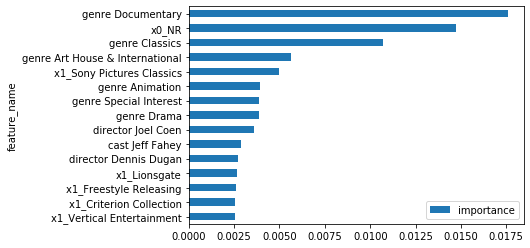

In [109]:
ax = df_feature.sort_values('importance', ascending=True)[-15:].plot.barh(y='importance',x = 'feature_name')

# Model Training: Audience_rating

In [110]:
from vecstack import stacking
from vecstack import StackingTransformer
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss, mean_squared_error, r2_score, auc
from sklearn.linear_model import LinearRegression
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.ensemble  import ExtraTreesRegressor, RandomForestRegressor
import lightgbm as lgb
from sklearn.neural_network import MLPRegressor

In [111]:
y_train_audience_rating

4544    75.00000
10467   78.00000
5160    79.00000
1382    10.00000
10373   39.00000
          ...   
4882    77.00000
10338   68.00000
9492    53.00000
7368    67.00000
7370    59.00000
Name: audience_rating, Length: 13108, dtype: float64

In [124]:
%%time
#Computing for each model with SMOTE sampling: accuracy, precision and recall 

linear_reg_audience_rating = LinearRegression()

XGB_audience_rating = XGBRegressor()

ridge_audience_rating = Ridge()

Passive_audience_rating = PassiveAggressiveRegressor()

Huber_audience_rating = HuberRegressor()

MLP_audience_rating = MLPRegressor(hidden_layer_sizes=(100,100,50), max_iter=2,activation = 'relu',solver='adam',random_state=1,verbose=10)


models=[linear_reg_audience_rating,XGB_audience_rating,ridge_audience_rating,Passive_audience_rating,Huber_audience_rating,MLP_audience_rating]

model_accuracy_train_audience_rating=[]
model_accuracy_test_audience_rating=[]

for model in models:
    print("\nNow training \n")
    print(type(model).__name__)
    model.fit(X_train, y_train_audience_rating)
    #model_accuracy_train.append(model.score(X_train, y_train_audience_rating))
    model_accuracy_test_audience_rating.append(mean_squared_error(y_test_audience_rating, model.predict(X_test)))
    model_accuracy_train_audience_rating.append(mean_squared_error(y_train_audience_rating, model.predict(X_train)))
    
    #report=precision_recall_fscore_support(y_test_audience_rating, model.predict(X_test))
    #precisions.append(report[0][1])
    #recalls.append(report[1][1])
   


Now training 

LinearRegression

Now training 

XGBRegressor

Now training 

Ridge

Now training 

PassiveAggressiveRegressor

Now training 

HuberRegressor


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html




Now training 

MLPRegressor
Iteration 1, loss = 1330.26739500
Iteration 2, loss = 217.43404803


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.



Wall time: 3min 28s


In [125]:
acc_train_df=pd.DataFrame(model_accuracy_train_audience_rating,index=['LinearRegression','XGBRegressor','Ridge','PassiveAggressiveRegressor','HuberRegressor','MLPRegressor'],columns=['acc_train'])
acc_test_df=pd.DataFrame(model_accuracy_test_audience_rating,index=['LinearRegression','XGBRegressor','Ridge','PassiveAggressiveRegressor','HuberRegressor','MLPRegressor'],columns=['acc_test'])
acc_test_df

model_accuracy=pd.concat([acc_train_df,acc_test_df], axis=1)
model_accuracy



,acc_train,acc_test
LinearRegression,160.24525,2355300533312258310144.00000
XGBRegressor,227.68114,310.30834
Ridge,170.29153,372.07448
PassiveAggressiveRegressor,218.48278,494.11524
HuberRegressor,184.51081,412.08764
MLPRegressor,327.32981,398.35908


In [114]:
pred_result = pd.DataFrame({'actual rating': y_test_audience_rating, 'pred rating': XGB_audience_rating.predict(X_test)})

In [115]:
pred_result.head(20)

,actual rating,pred rating
5234,90.00000,63.19268
9036,46.00000,49.24849
11273,39.00000,45.92232
3947,35.00000,45.42601
15398,71.00000,64.13646
7731,55.00000,65.61474
15160,77.00000,44.36432
12562,19.00000,76.61321
12382,52.00000,48.58292
7502,70.00000,51.39419


## XGBoost Result GridSearch

In [116]:
# Various hyper-parameters to tune
xgb1 = XGBRegressor()


parameters = {'objective':['reg:linear'],
              'learning_rate': [0.2, 0.3], #so called `eta` value
              'max_depth': [4],
              'min_child_weight': [1, 2],
              'silent': [1],
              'subsample': [0.8, 0.9],
              'colsample_bytree': [0.8],
              'n_estimators': [200, 300]}

xgb_grid_audience = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        #scoring = 'neg_mean_squared_error',
                        n_jobs = 8,
                        verbose=True)

xgb_grid_audience.fit(X_train, y_train_audience_rating)

Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  32 out of  32 | elapsed: 19.7min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estima...
                                    subsample=None, tree_method=None,
                                    validate_parameters=False, verbosity=None),
             iid='deprecated', n_jobs=8,
             param_grid={'colsample_bytree': [0.8], 'learning_rate': [0.2, 0.3],
                    

In [117]:
print(xgb_grid_audience.best_score_)
print(xgb_grid_audience.best_params_)

0.2682351035166872
{'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 200, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.9}


## XGBoost Result

In [118]:
pred_result = pd.DataFrame({'actual rating': y_test_audience_rating, 'pred rating': xgb_grid_audience.predict(X_test)})

In [119]:
pred_result.head(10)

,actual rating,pred rating
5234,90.00000,63.94885
9036,46.00000,49.01633
11273,39.00000,50.44814
3947,35.00000,48.64257
15398,71.00000,63.08348
7731,55.00000,64.53970
15160,77.00000,50.63872
12562,19.00000,79.25253
12382,52.00000,52.86232
7502,70.00000,52.19017


In [120]:
feature_importance = xgb_grid_audience.best_estimator_.feature_importances_
d = {'feature_name': X.columns, 'importance': feature_importance}
df_feature_audience = pd.DataFrame(data=d)

In [121]:
df_feature_audience

,feature_name,importance
0,runtime_in_minutes,0.00269
1,genre Action & Adventure,0.00116
2,genre Animation,0.00834
3,genre Anime & Manga,0.00000
4,genre Art House & International,0.00511
...,...,...
5517,x1_Wolfe Releasing,0.00000
5518,x1_Xlrator Media,0.00347
5519,x1_Yari Film Group,0.00000
5520,x1_Yash Raj Films,0.00000


In [122]:
df_feature_audience.sort_values('importance', ascending=False)[:15]

,feature_name,importance
12,genre Horror,0.02828
8,genre Documentary,0.02274
5,genre Classics,0.01646
18,genre Special Interest,0.01097
2,genre Animation,0.00834
5341,x1_Criterion Collection,0.00576
4,genre Art House & International,0.00511
5469,x1_Sony Pictures Classics,0.00441
1955,cast Akshay Kumar,0.00439
15,genre Mystery & Suspense,0.00413


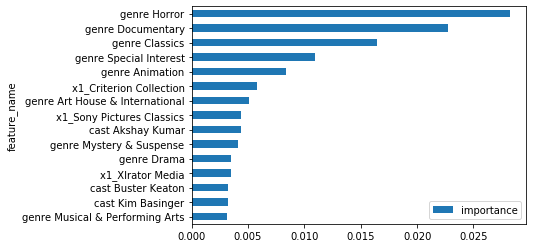

In [123]:
ax = df_feature_audience.sort_values('importance', ascending=True)[-15:].plot.barh(y='importance',x = 'feature_name')